# Credit
Copied directly from https://github.com/pymc-devs/pymc-examples/blob/main/examples/case_studies/BART_introduction.ipynb

(BART_introduction)=
# Bayesian Additive Regression Trees: Introduction
:::{post} Dec 21, 2021
:tags: BART, non-parametric, regression 
:category: intermediate, explanation
:author: Osvaldo Martin
:::

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import rust_pgbart as pmb

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [2]:
RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## BART overview

Bayesian additive regression trees (BART) is a non-parametric regression approach. If we have some covariates $X$ and we want to use them to model $Y$, a BART model (omitting the priors) can be represented as:

$$Y = f(X) + \epsilon$$

where we use a sum of $m$ [regression trees](https://en.wikipedia.org/wiki/Decision_tree_learning) to model $f$, and $\epsilon$ is some noise. In the most typical examples $\epsilon$ is normally distributed, $\mathcal{N}(0, \sigma)$. So we can also write:

$$Y \sim \mathcal{N}(\mu=BART(X), \sigma)$$

In principle nothing restricts us to use a sum of trees to model other relationship. For example we may have:

$$Y \sim \text{Poisson}(\mu=BART(X))$$

One of the reason BART is Bayesian is the use of priors over the regression trees. The priors are defined in such a way that they favor shallow trees with leaf values close to zero. A key idea is that a single BART-tree is not very good at fitting the data but when we sum many of these trees we get a good and flexible approximation.

## Coal mining with BART

To better understand BART in practice we are going to use the oldie but goldie coal mining disaster dataset. One of the classic examples in PyMC. Instead of thinking this problem as a switch-point model with two Poisson distribution, as in the original PyMC example. We are going to think this problem as a non-parametric regression with a Poisson response (this is usually discussed in terms of [Poisson processes](https://en.wikipedia.org/wiki/Poisson_point_process) or [Cox processes](https://en.wikipedia.org/wiki/Cox_process), but we are OK without going into those technicalities). For a similar example but with Gaussian processes see [1](https://github.com/aloctavodia/BAP/blob/master/code/Chp7/07_Gaussian%20process.ipynb) or [2](https://research.cs.aalto.fi/pml/software/gpstuff/demo_lgcp.shtml). Because our data is just a single column with dates, we need to do some pre-processing. We are going to discretize the data, just as if we were building a histogram. We are going to use the centers of the bins as the variable $X$ and the counts per bin as the variable $Y$

In [3]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

In PyMC a BART variable can be defined very similar to other random variables. One important difference is that we have to pass ours Xs and Ys to the BART variable, this information is used when sampling trees, the prior over the sum of trees is so huge that without any information from our data this will be an impossible task. 

Here we are also making explicit that we are going to use a sum over 20 trees (`m=20`). Low number of trees like 20 could be good enough for simple models like this and could also work very good as a quick approximation for more complex models in particular during the early stage of modeling, when we may want to try a few things as quickly as possible in order to better grasp which model may be a good idea for our problem. In those cases once we have more certainty about the model(s) we really like we can improve the approximation by increasing `m`, in the literature is common to find reports of good results with numbers like 50, 100 or 200.

In [5]:
with pm.Model() as model_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=np.log(y_data), m=20)
    μ = pm.Deterministic("μ", pm.math.exp(μ_))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Before checking the result, we need to discuss one more detail, the BART variable always samples over the real line, meaning that in principle we can get values that go from $-\infty$ to $\infty$. Thus, we may need to transform their values as we would do for standard Generalized Linear Models, for example in the `model_coal` we computed `pm.math.exp(μ_)` because the Poisson distribution is expecting values that go from 0 to $\infty$. This is business as usual, the novelty is that we may need to apply the inverse transformation to the values of `Y`, as we did in the previous model where we took $\log(Y)$. The main reason to do this is that the values of `Y` are used to get a reasonable initial value for the sum of trees and also the variance of the leaf nodes. Thus, applying the inverse transformation is a simple way to improve the efficiency and accuracy of the result. Should we do this for every possible likelihood? Well, no. If we are using BART for the location parameter of distributions like Normal, StudentT, or AssymetricLaplace, we don't need to do anything as the support of these parameters is also the real line. A nontrivial exception is the Bernoulli likelihood (or Binomial with n=1), in that case, we need to apply the logistic function to the BART variable, but there is no need to apply its inverse to transform `Y`, PyMC-BART already takes care of that particular case.

OK, now let's see the result of `model_coal`.

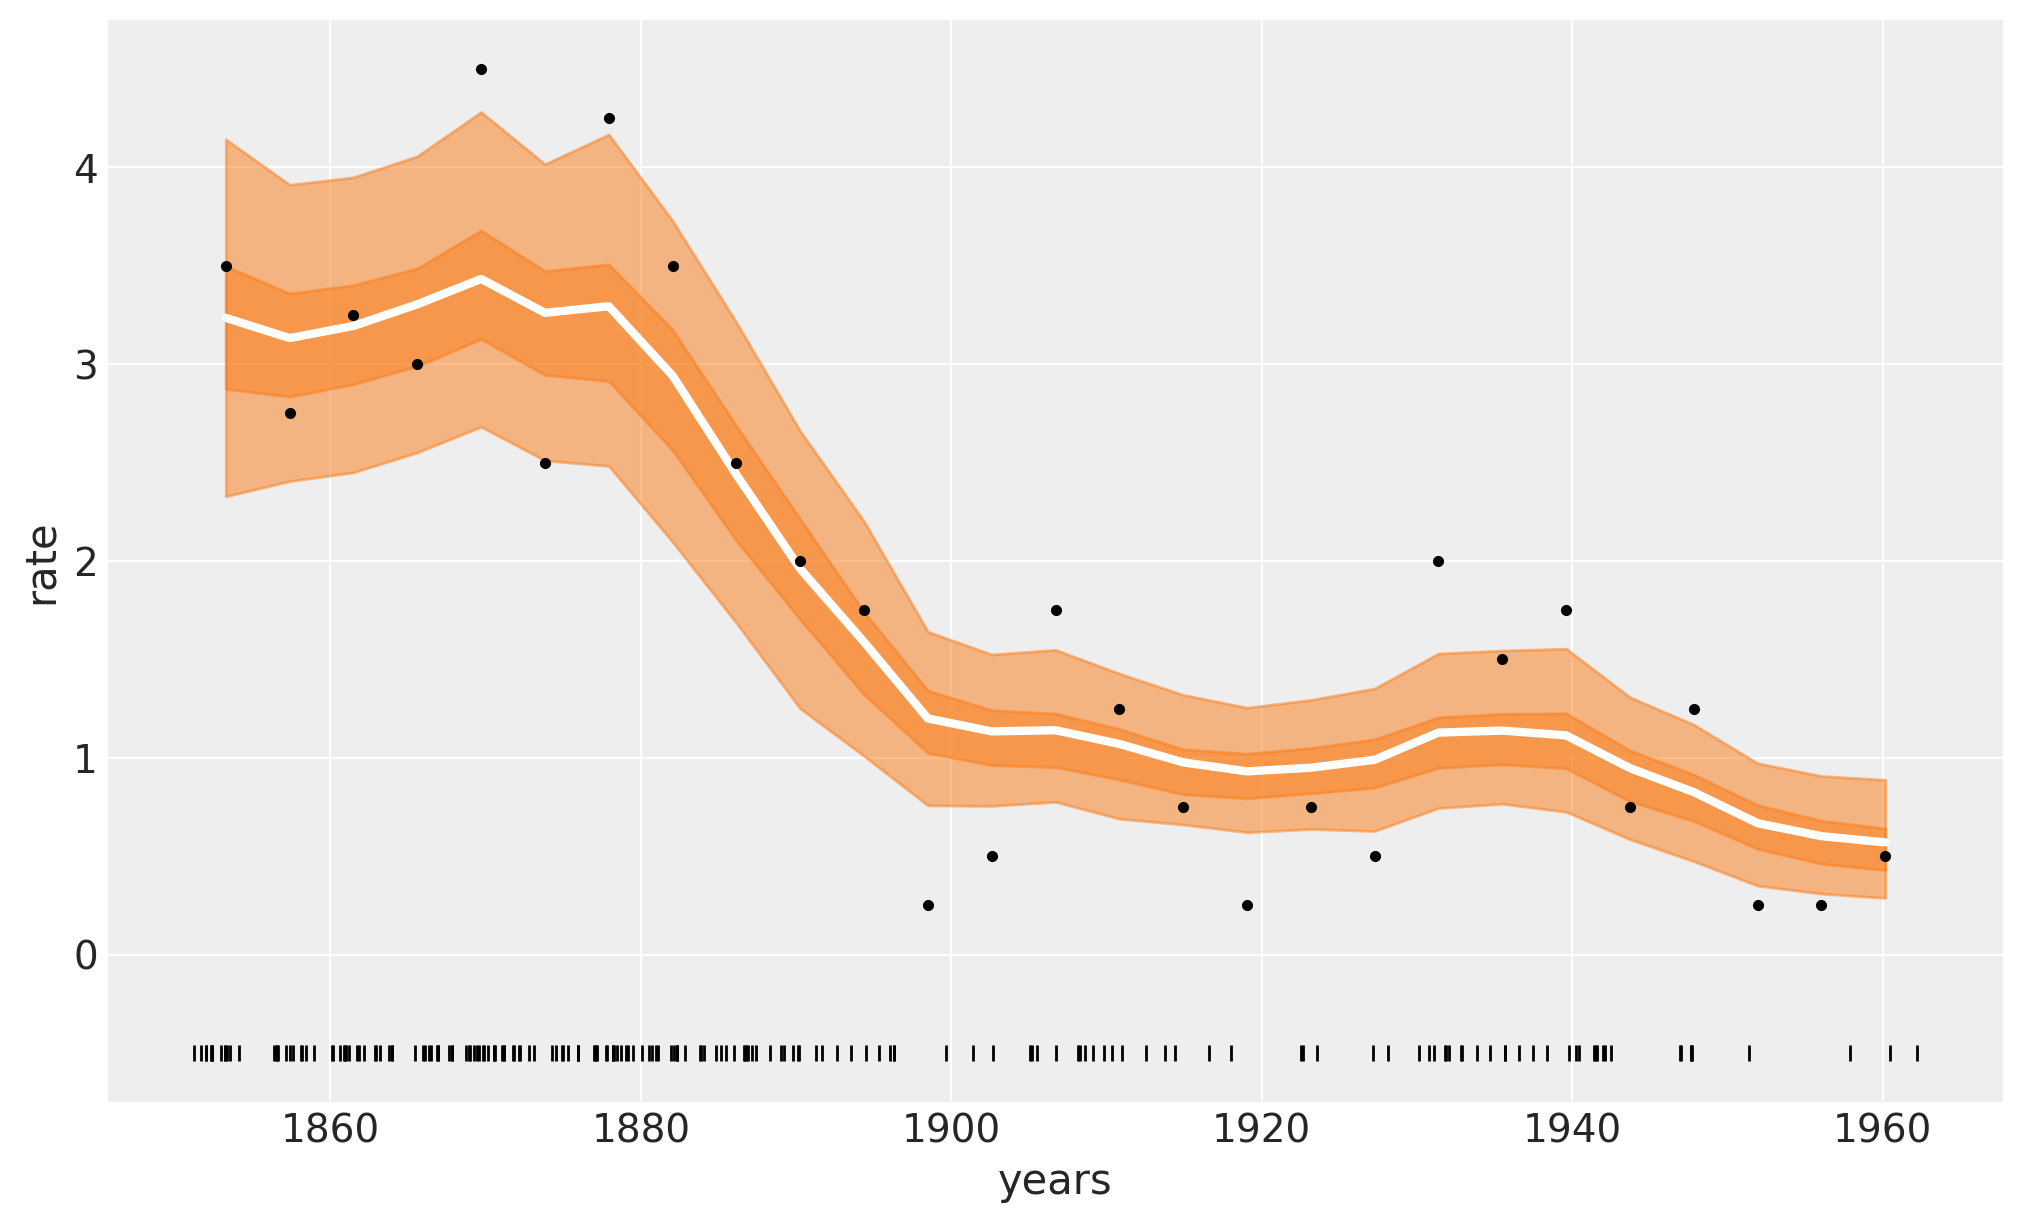

In [6]:
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

The white line in the following plot shows the median rate of accidents. The darker orange band represent the HDI 50% and the lighter one the 94%. We can see a rapid decrease of coal accidents between 1880 and 1900. Feel free to compare these results with those in the original {ref}`pymc:pymc_overview` example.

In the previous plot the white line is the mean over 4000 posterior draws, and each one of those posterior draws is a sum over `m=20` trees. 


The following figure shows two samples from the posterior of $\mu$. We can see that these functions are not smooth. This is fine and is a direct consequence of using regression trees. Trees can be seen as a way to represent stepwise functions, and a sum of stepwise functions is just another stepwise function. Thus, when using BART we just need to know that we are assuming that a stepwise function is a good enough approximation for our problem. In practice this is often the case because we sum over many trees, usually values like 50, 100 or 200. Additionally, we often average over the posterior distribution. All this makes the "steps smoother", even when we never really have an smooth function as for example with Gaussian processes (splines). A nice theoretical result, tells us that in the limit of $m \to \infty$ the BART prior converges to a [nowheredifferentiable](https://en.wikipedia.org/wiki/Weierstrass_function) Gaussian process.

The following figure shows two samples of $\mu$ from the posterior.

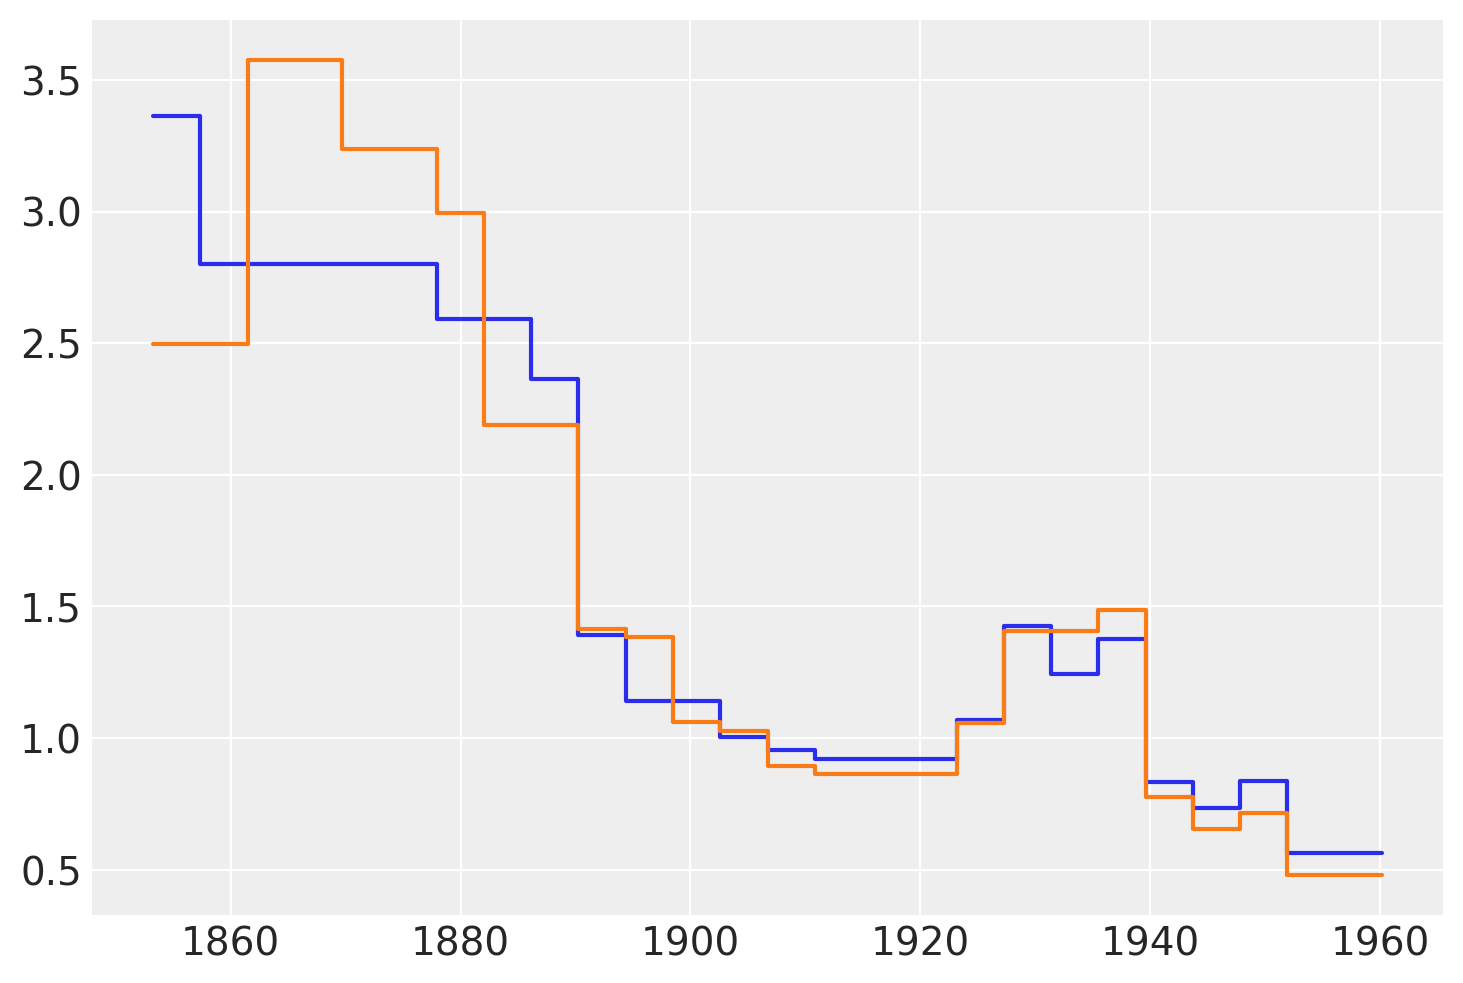

In [7]:
plt.step(x_data, rates.sel(chain=0, draw=[3, 10]).T);

## Biking with BART

To explore other features offered by BART in PyMC. We are now going to move on to a different example. In this example we have data about the  number of bikes rental in a city, and we have chosen four covariates; the hour of the day, the temperature, the humidity and whether is a workingday or a weekend. This dataset is a subset of the [bike_sharing_dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [8]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

features = ["hour", "temperature", "humidity", "workingday"]

X = bikes[features]
Y = bikes["count"]

In [9]:
with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False, random_seed=RANDOM_SEED)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


### Convergence diagnostics

To check sampling convergence of BART models we recommend a 2 step approach. 

* For the non-BART variables (like $\alpha$ in `model_bikes`) we follow the standard recommendations, like checking R-hat (<= 1.01), and ESS (< 100x number of chains) numerical diagnostics as well as using trace plots or even better rankplots
* For the BART variables we recommend using the `pmb.plot_convergence` function. 

We can see such checks next:

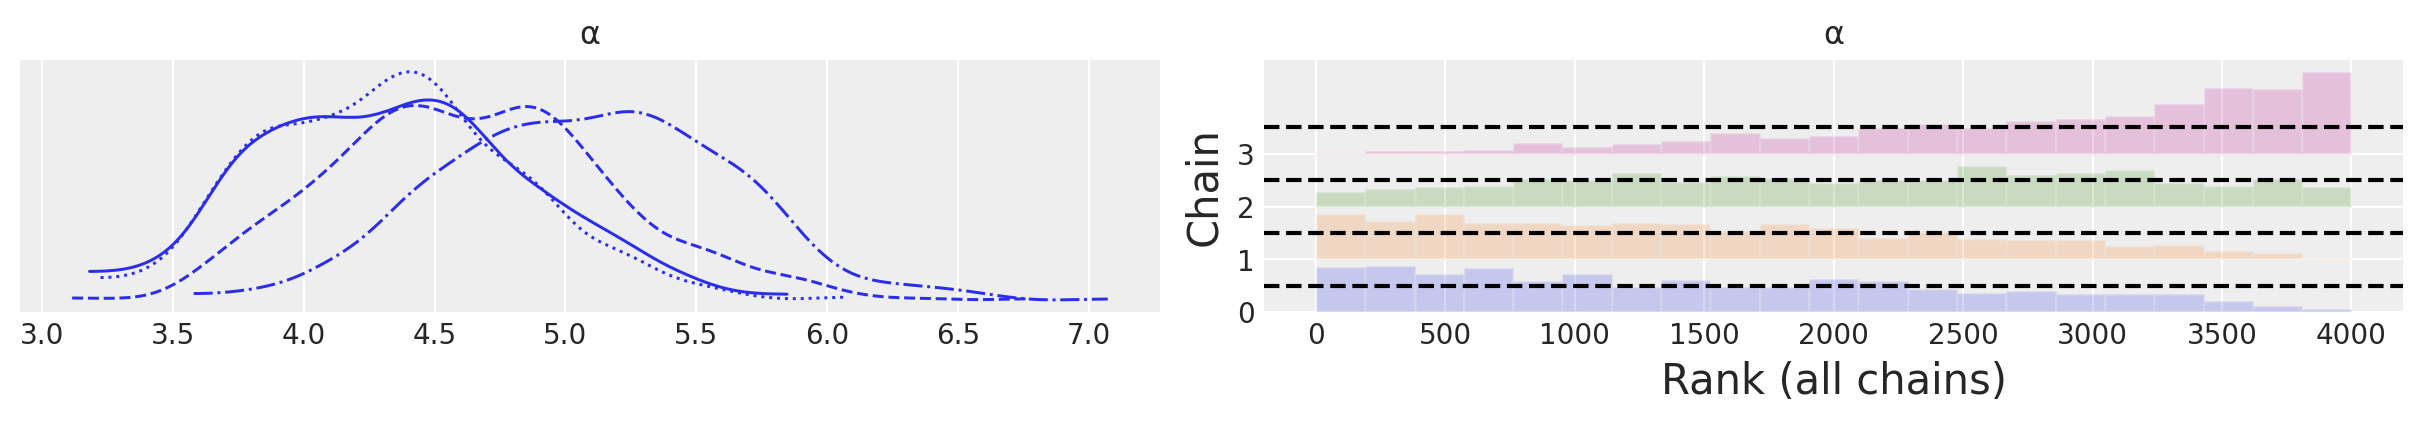

In [10]:
az.plot_trace(idata_bikes, var_names=["α"], kind="rank_bars");

## Authors
* Authored by Osvaldo Martin in Dec, 2021 ([pymc-examples#259](https://github.com/pymc-devs/pymc-examples/pull/259))
* Updated by Osvaldo Martin in May, 2022  ([pymc-examples#323](https://github.com/pymc-devs/pymc-examples/pull/323))
* Updated by Osvaldo Martin in Sep, 2022
* Updated by Osvaldo Martin in Nov, 2022
* Juan Orduz added out-of-sample section in Jan, 2023
* Updated by Osvaldo Martin in Mar, 2023

## References

:::{bibliography}
:filter: docname in docnames

martin2021bayesian
quiroga2022bart
:::

## Watermark

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Apr 05 2023

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

rust_pgbart: 0.1.0
pymc       : 5.2.0
matplotlib : 3.5.2
pandas     : 1.5.3
arviz      : 0.15.1
numpy      : 1.23.5

Watermark: 2.3.1



:::{include} ../page_footer.md
:::